![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/soilmechanics

# Günther-Salzer model -- damage free component

Following:

Günther, R.-M., Salzer, K., Popp, T., & Lüdeling, C. (2015). Steady-State Creep of Rock Salt: Improved Approaches for Lab Determination and Modelling. Rock Mechanics and Rock Engineering, 48(6), 2603–2613. https://doi.org/10.1007/s00603-015-0839-2

Günther, R., & Salzer, K. (2012). Advanced strain-hardening approach. In Mechanical Behaviour of Salt VII (Issue December 2016). CRC Press. https://doi.org/10.1201/b12041-4

\begin{align}
    \dot{\epsilon}_\text{cr} &= \dot{\epsilon}_\text{cr}^\text{V} + \dot{\epsilon}_\text{cr}^\text{E}
    \\
    \dot{\epsilon}_\text{cr} &= A_\text{p} \frac{ (\bar{\sigma}/\sigma_\text{ref})^{n_\text{p}}}{\left( \epsilon^\text{V}_0 + \epsilon_\text{cr}^\text{V} \right)^{\mu_\text{p}}} \quad \text{with} \quad \bar{\sigma} = \sqrt{\frac{3}{2}} \left\lVert \mathbf{s} \right\rVert
    \\
    \dot{\epsilon}_\text{cr}^\text{E} &= \sum \limits_{i=1}^2 A_{\text{s},i} \exp \left( - \frac{Q_i}{RT} \right) \left( \frac{\bar{\sigma}}{\sigma_\text{ref}} \right)^{n_i}
\end{align}

3D:

$$
    \dot{\boldsymbol\epsilon}_\text{cr} = \sqrt{\frac{3}{2}} \dot{\epsilon}_\text{cr} \frac{\mathbf{s}}{\left\lVert \mathbf{s} \right\rVert}
$$

In [1]:
#HIDDEN
import mtest
import numpy as np
import matplotlib.pyplot as plt
import os
import plot_settings
mtest.setVerboseMode(mtest.VerboseLevel.VERBOSE_QUIET)

In [2]:
#HIDDEN
build_release = 'mfront --obuild --interface=generic GuentherSalzerDilatancy_semi_expl.mfront'
#os.system(build_release)

## Dilatancy tests

In [3]:
E = 25e4 #MPa
nu = 0.27
#
Ap = 5.5e-40 #1/d
npe = 10.6
s0 = 1.0 #MPa
mup = 5.25
epsv0 = 0.0001 # very sensitive parameter!
#
As1 = 0.05
Q1 = 40e3
ns1 = 4.0
As2 = 0.02
Q2 = 65e3
ns2 = 1.0

In [4]:
#HIDDEN
def run_creep_Asse_dil(T = 299, t1=45, t2 = 30, sdiff1=-25, sdiff2 = -25, s3 = -20.):
    t_discrete = np.linspace(0,t1+t2,1000)
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(10)
    m.setBehaviour('generic', './src/libBehaviour.so', 'GuentherSalzerDilatancy_semi_expl')
    m.setImposedStress('SXX', s3)
    m.setImposedStress('SYY', s3)
    m.setImposedStress('SZZ', {0: s3, t1/100:s3+sdiff1, t1: s3+sdiff1, t1+t2/100: s3+sdiff2, t2+t1: s3+sdiff2})
    m.setImposedStress('SXZ', 0.0)
    m.setImposedStress('SYZ', 0.0)
    m.setImposedStress('SXY', 0.0)
    m.setMaterialProperty('YoungModulus', E)
    m.setMaterialProperty('PoissonRatio', nu)
    m.setMaterialProperty('PrimaryPowerLawFactor', Ap)
    m.setMaterialProperty('PrimaryPowerLawExponent', npe)
    m.setMaterialProperty('SecondaryPowerLawFactor1', As1)
    m.setMaterialProperty('SecondaryPowerLawExponent1', ns1)
    m.setMaterialProperty('SecondaryActivationEnergy1', Q1)
    m.setMaterialProperty('SecondaryPowerLawFactor2', As2)
    m.setMaterialProperty('SecondaryPowerLawExponent2', ns2)
    m.setMaterialProperty('SecondaryActivationEnergy2', Q2)
    m.setMaterialProperty('HardeningExponent', mup)
    m.setMaterialProperty('InitialHardening', epsv0)
    m.setMaterialProperty('ReferenceStress', s0)
    m.setExternalStateVariable("Temperature", 333)
    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = np.array([0.])
    Udil = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        p = s.getInternalStateVariableValue('DilatancyWork')
        Udil = np.append(Udil,p)
        numerical = np.append(numerical,s.e1[2])#effective strain
    return t_discrete, numerical, Udil

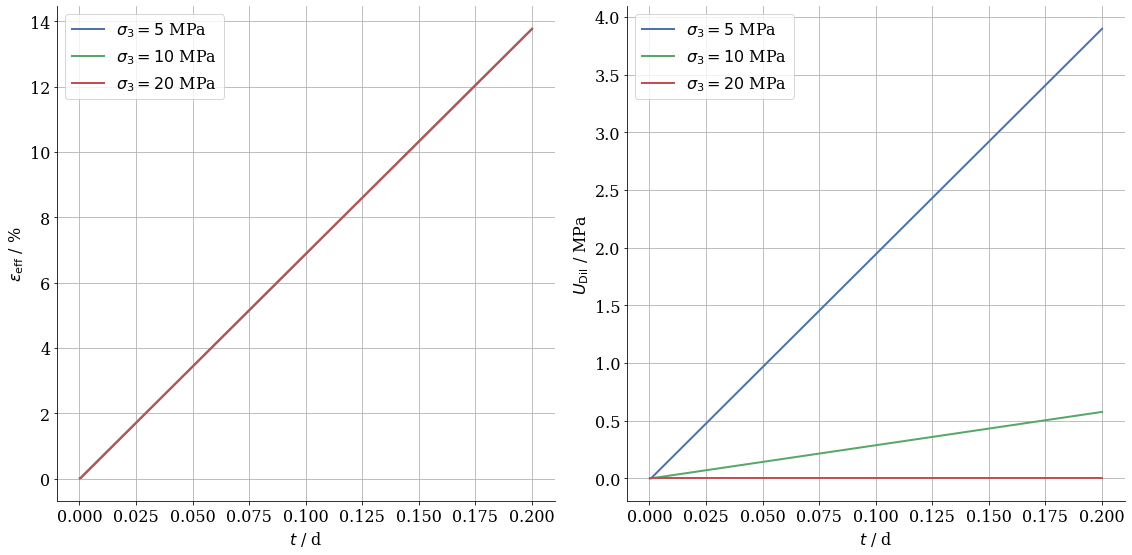

In [5]:
#HIDDEN
fig,ax = plt.subplots(figsize=(16,8),ncols=2)
for sig3 in [5,10,20]:
    t, e, u = run_creep_Asse_dil(T = 293, t1 = 0.1, t2 = .1, sdiff1 = -60, sdiff2 = -60, s3 = -sig3)
    ax[0].plot(t[1:],-e[1:]*100, label= '$\\sigma_3 = %i$ MPa' %sig3)
    ax[1].plot(t[1:],u[1:], label= '$\\sigma_3 = %i$ MPa' %sig3)

ax[0].set_xlabel('$t$ / d')
ax[0].set_ylabel('$\\epsilon_\\mathrm{eff}$ / %')
ax[0].grid('both')
ax[0].legend()


ax[1].set_xlabel('$t$ / d')
ax[1].set_ylabel('$U_\\mathrm{Dil}$ / MPa')
ax[1].grid('both')
ax[1].legend()
fig.tight_layout();